# Uncertainty 

This is a tutorial for the uncertainty module.

## Uncertainty and sensitivity analysis?

Before doing an uncertainty analysis in CLIMADA, it is imperative that you get first comfortable with the different notions of uncertainty in the modelling world (see e.g. [Douglas-Smith(2020)](https://doi.org/10.1007/978-1-4899-7547-8_5) for a review). In particular, note that the uncertaintity values will only be as good as the input from the user. In addition, not all uncertainties can be numerically quantified, and even worse, some unkonwns are unknown. This means that sometimes, quantifying uncertainty can lead to false confidence in the output!. For a more philosophical discussion about the types of uncertainties in climate research see [Knüsel2020](https://www.research-collection.ethz.ch/handle/20.500.11850/399735).

In this module, it is possible to perform global uncertainty analysis, as well as a sensitivity analysis. The word global is meant as opposition to the 'one-factor-at-a-time' (OAT) strategy. The OAT strategy, which consists in analyzing the effect of varying one model input factor at a time while keeping all other fixed, is popular among modellers, but has major shortcomings [Saltelli (2010)](https://www.sciencedirect.com/science/article/abs/pii/S1364815210001180), [Saltelli(2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822) and should not be used.

A rough schemata of how to perform uncertainty and sensitivity analysis (taken from [Saltelli(2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822))

<img src="./img/UncertaintySensitivity.jpg" alt="Uncertainty and Sensitivity analysis" width="600">

1. [Douglas-Smith, D., Iwanaga, T., Croke, B. F. W. & Jakeman, A. J. Certain trends in uncertainty and sensitivity analysis: An overview of software tools and techniques. Environmental Modelling & Software 124, 104588 (2020)](https://doi.org/10.1007/978-1-4899-7547-8_5)
2. [Knüsel, B. Epistemological Issues in Data-Driven Modeling in Climate Research. (ETH Zurich, 2020)](https://www.research-collection.ethz.ch/handle/20.500.11850/399735)
3. [Saltelli, A. et al. Why so many published sensitivity analyses are false: A systematic review of sensitivity analysis practices. Environmental Modelling & Software 114, 29–39 (2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822)
4. [Saltelli, A. & Annoni, P. How to avoid a perfunctory sensitivity analysis. Environmental Modelling & Software 25, 1508–1517 (2010)](https://www.sciencedirect.com/science/article/abs/pii/S1364815210001180)

##  Uncertainty Module Structure

The uncertainty module contains 2 main classes
- `UncVar`: defines uncertainty variables
- `Uncertainty`: base class to compute uncertainties and sensitivities for CLIMADA outputs.

In addition, there are the child classes of `Uncertainty` defined in their submodules:

- `UncImpact`: specific class to compute uncertainties for outputs of `climada.engine.impact.calc`
- `UncCostBenefit`: specific class to compute uncertainties for outputs of `climada.engine.cost_benefit.calc`

## UncVar 

The UncVar class is used to define uncertainty variables. 

| Attribute | Type | Description |
| --- | --- | --- |
| uncvar_func | funnction | Variable defined as a function of the uncertainty parameters |
| distr_dict | dict | Dictionary of the probability density distributions of the uncertainty parameters |

An **uncertainty parameter** is an input value that has a certain probability density distribution in your model, such as the total exposure asset value, the slope the vulnerability function, the exponent of the litpop exposure,  the value of the discount rate, the cost of an adaptation measure, ... 

The probability densitity distributions (values of `distr_dict`) of the uncertainty parameters (keyword arguments of the `uncvar_func` and keys of the `distr_dict`) can be any of the ones defined in [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html).

### Example - continuous uncertainty parameter

Suppose we assume that the GDP value used to scale the exposure has a relative error of +-10%. 

In [3]:
#Define the base exposure
from climada.entity import Exposures
exp_base = Exposures()
exp_base.read_hdf5(EXP_DEMO_H5)

2021-03-25 11:51:02,084 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-25 11:51:02,085 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-25 11:51:02,086 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-25 11:51:02,087 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-25 11:51:02,089 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-25 11:51:02,090 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5
2021-03-25 11:51:02,110 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-25 11:51:02,110 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-25 11:51:02,111 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-25 11:51:02,111 - climada.entity.exposures.base - INF

In [4]:
# Define the function that returns an exposure with scaled total assed value
# Here x_exp is the uncertainty parameter and exp_func the uncvar_func.
def exp_func(x_exp, exp_base=exp_base):
    exp = exp_base.copy()
    exp.gdf.value *= x_exp
    return exp

In [6]:
# Define the Uncertainty Variable with +-10% total asset value
# The probability density distribution of the uncertainty parameter x_exp is sp.stats.uniform(0.9, 1.1)
from climada.engine.uncertainty import UncVar
import scipy as sp

exp_distr = {"x_exp": sp.stats.uniform(0.9, 1.1),
              }
exp_unc = UncVar(exp_func, exp_distr)

In [7]:
# Uncertainty parameters
exp_unc.labels

['x_exp']

In [8]:
# Evaluate for a given value of the uncertainty parameters
exp095 = exp_unc.evaluate({'x_exp': 0.95})
print(f"Base value is {exp_base.gdf['value'].sum()}, and the value for x_exp=0.95 is {exp095.gdf['value'].sum()}")

Base value is 657053294559.9105, and the value for x_exp=0.95 is 624200629831.9148


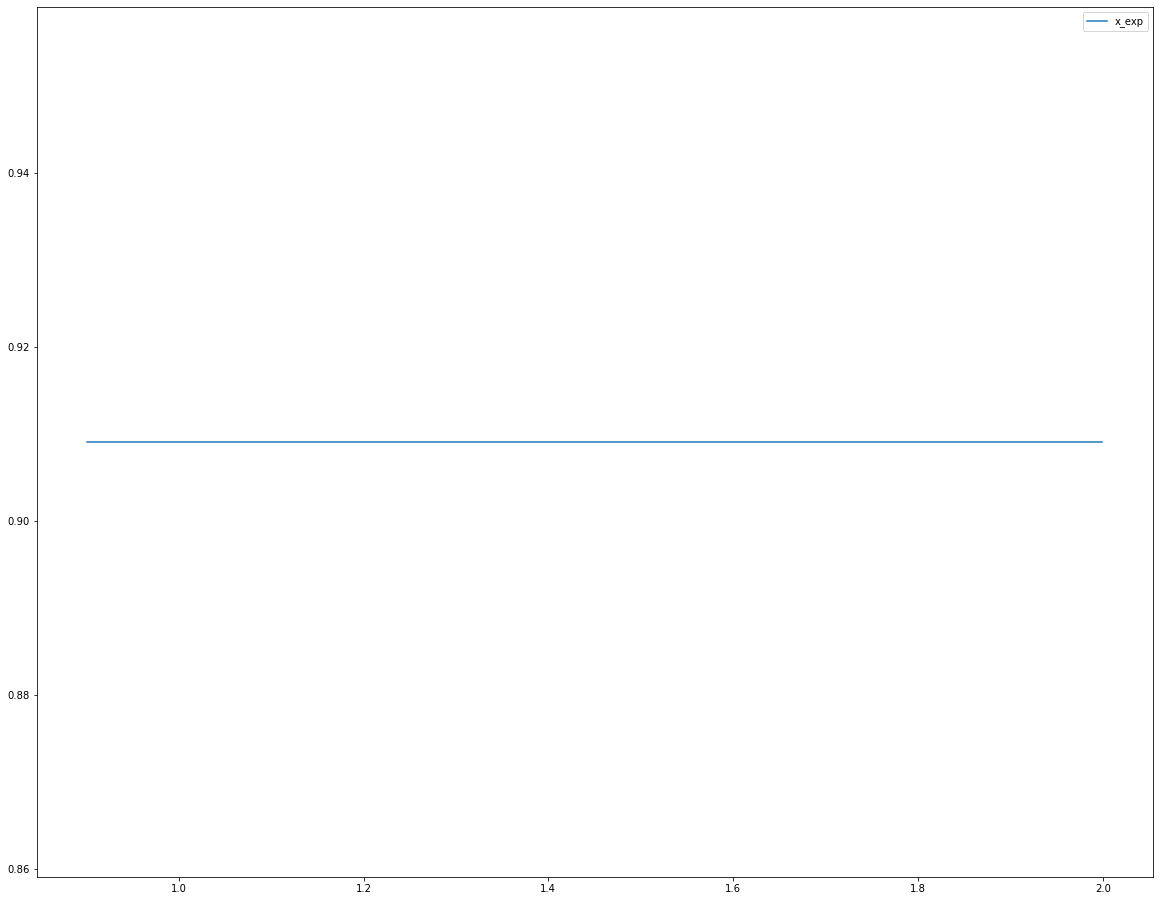

In [9]:
# Defined distribution
exp_unc.plot();

### Example - categorical uncertainty parameter 

Suppose we want to test different exponents (m=0,1,2 ; n=0,1,2) for the LitPop exposure for the country Switzerland.

In [1]:
from climada.entity import LitPop

m_min, m_max = (0, 2)
n_min, n_max = (0, 2)

# Define the function
# Note that this here works, but might be slow because the method LitPop is called everytime the the function
# is evaluated, and LitPop is relatively slow. 
def litpop_cat(m, n):
    exp = Litpop()
    exp.set_country('CHE', exponent=[m, n])
    return exp

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# A faster method would be to first create a dictionnary with all the exposures. This however
# requires more memory and precomputation time
exp = LitPop()
litpop_dict = {}
for m in range(m_min, m_max + 1):
    for n in range(n_min, n_max + 1):
        exp_mn = exp.copy()
        exp_mn.set_country('CHE', exponent=[m, n])
        litpop_dict[(m, n)] = exp_mn
        
def litpop_cat(m, n, litpop_dict=litpop_dict):
    return litpop_dict[(m, n)]

2021-03-26 10:39:04,442 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 10:39:04,443 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 10:39:04,444 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 10:39:04,445 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 10:39:04,447 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 10:39:05,908 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-26 10:39:15,590 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-26 10:39:15,591 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-26 10:39:29,493 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-26 10:39:29,937 - climada.util.finance 

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-03-26 10:39:32,012 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-26 10:39:41,755 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-26 10:39:41,756 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-26 10:39:53,746 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-26 10:39:54,176 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-03-26 10:39:54,817 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 10:39:54,818 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 10:39:54,818 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 10:39:54,819 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 10:39:54,835 - climada.entity.exposures.base - INFO - cr

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-03-26 10:39:56,246 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-26 10:40:05,808 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-26 10:40:05,809 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-26 10:40:17,512 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-26 10:40:17,938 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-03-26 10:40:18,656 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 10:40:18,657 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 10:40:18,657 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 10:40:18,657 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 10:40:18,673 - climada.entity.exposures.base - INFO - cr

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-03-26 10:40:20,066 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-26 10:40:29,715 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-26 10:40:29,716 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-26 10:40:41,461 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-26 10:40:41,896 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-03-26 10:40:42,608 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 10:40:42,609 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 10:40:42,610 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 10:40:42,610 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 10:40:42,627 - climada.entity.exposures.base - INFO - cr

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-03-26 10:40:43,993 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-26 10:40:53,825 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-26 10:40:53,825 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-26 10:41:05,747 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-26 10:41:06,188 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-03-26 10:41:06,816 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 10:41:06,817 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 10:41:06,817 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 10:41:06,817 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 10:41:06,833 - climada.entity.exposures.base - INFO - cr

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-03-26 10:41:08,184 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-26 10:41:17,663 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-26 10:41:17,663 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-26 10:41:29,251 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-26 10:41:29,683 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-03-26 10:41:30,391 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 10:41:30,391 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 10:41:30,392 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 10:41:30,392 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 10:41:30,412 - climada.entity.exposures.base - INFO - cr

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-03-26 10:41:31,857 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-26 10:41:41,697 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-26 10:41:41,698 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-26 10:41:53,469 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-26 10:41:53,924 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-03-26 10:41:54,637 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 10:41:54,638 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 10:41:54,638 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 10:41:54,638 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 10:41:54,655 - climada.entity.exposures.base - INFO - cr

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-03-26 10:41:55,937 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-26 10:42:05,705 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-26 10:42:05,706 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-26 10:42:17,637 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-26 10:42:18,064 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-03-26 10:42:18,685 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 10:42:18,685 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 10:42:18,686 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 10:42:18,686 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 10:42:18,703 - climada.entity.exposures.base - INFO - cr

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-03-26 10:42:20,065 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-03-26 10:42:29,647 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-03-26 10:42:29,647 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-03-26 10:42:41,365 - climada.util.finance - INFO - GDP CHE 2014: 7.092e+11.
2021-03-26 10:42:41,797 - climada.util.finance - INFO - GDP CHE 2016: 6.713e+11.
2021-03-26 10:42:42,507 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 10:42:42,508 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 10:42:42,508 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 10:42:42,509 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 10:42:42,527 - climada.entity.exposures.base - INFO - cr

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


In [4]:
#Define the distribution dictionnary
import scipy as sp
from climada.engine.uncertainty import UncVar

distr_dict = {
    'm': sp.stats.randint(low=m_min, high=m_max),
    'n': sp.stats.randint(low=n_min, high=n_max)
    }

unc_var_cat = UncVar(litpop_cat, distr_dict) # One can use either of the above definitions of litpop_cat

In [5]:
# Uncertainty parameters
unc_var_cat.labels

['m', 'n']

##  UncImpact

### Set the UncVars 

import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from pathos.pools import ProcessPool as Pool

from climada.engine.uncertainty import UncVar, Uncertainty, UncImpact, UncCostBenefit
from climada.entity import ImpactFunc, ImpactFuncSet, Exposures
from climada.entity.entity_def import Entity
from climada.hazard import Hazard
from climada.util.value_representation import value_to_monetary_unit as vtm
from climada.util.plot import multibar_plot
from climada.util.constants import EXP_DEMO_H5, HAZ_DEMO_H5, ENT_DEMO_TODAY, ENT_DEMO_FUTURE

In this example, we model the impact function for tropical cyclones on the parametric function suggested in Emanuel (2015) with 4 parameters. The exposures total value varies between 80% and 120%. For that hazard, we assume to have no good error estimate and thus do not define an UncVar for the hazard.

In [6]:
#Define the uncvar_funcs
import numpy as np

from climada.entity import ImpactFunc, ImpactFuncSet, Exposures
from climada.util.constants import EXP_DEMO_H5, HAZ_DEMO_H5
from climada.hazard import Hazard

def impf_func(G=1, v_half=84.7, vmin=25.7, k=3, _id=1):    
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'TC'
    imp_fun.id = _id
    imp_fun.intensity_unit = 'm/s'
    imp_fun.intensity = np.linspace(0, 150, num=100)
    imp_fun.mdd = np.repeat(1, len(imp_fun.intensity))
    imp_fun.paa = np.array([sigmoid_func(v, G, v_half, vmin, k) for v in imp_fun.intensity])
    imp_fun.check()
    impf_set = ImpactFuncSet()
    impf_set.append(imp_fun)
    return impf_set

def xhi(v, v_half, vmin):
    return max([(v - vmin), 0]) / (v_half - vmin)
  
def sigmoid_func(v, G, v_half, vmin, k):
    return G * xhi(v, v_half, vmin)**k / (1 + xhi(v, v_half, vmin)**k)

haz = Hazard()
haz.read_hdf5(HAZ_DEMO_H5)

exp_base = Exposures()
exp_base.read_hdf5(EXP_DEMO_H5)
#It is a good idea to assign the centroids to the base exposures in order to avoid repeating this
# potentially costly operation for each sample.
exp_base.assign_centroids(haz) 

def exp_func(x_exp, exp_base=exp_base):
    exp = exp_base.copy()
    exp.gdf.value *= x_exp
    exp.check()
    return exp


2021-03-26 10:43:11,340 - climada.hazard.base - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5
2021-03-26 10:43:11,369 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 10:43:11,370 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 10:43:11,371 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-26 10:43:11,372 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-26 10:43:11,374 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-26 10:43:11,375 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5
2021-03-26 10:43:11,448 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-26 10:43:11,449 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-26 10:43:11,449 - climada.entity.exposu

2021-03-26 10:43:11,871 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


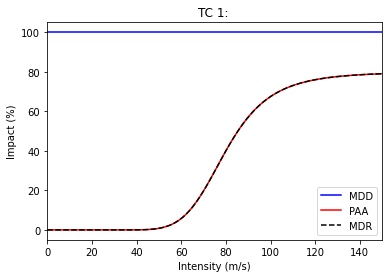

In [7]:
# Visualization of the parametrized impact function
impf_func(G=0.8, v_half=80, vmin=30,k=5).plot()

In [8]:
#Define the UncVars

import scipy as sp
from climada.engine.uncertainty import UncVar

exp_distr = {"x_exp": sp.stats.beta(0.8, 1.2),
              }
exp_unc = UncVar(exp_func, exp_distr)

impf_distr = {
    "G": sp.stats.truncnorm(0.8,1.2),
    "v_half": sp.stats.uniform(35, 100),
    "vmin": sp.stats.uniform(0, 15),
    "k": sp.stats.uniform(1, 5)
    }
impf_unc = UncVar(impf_func, impf_distr)

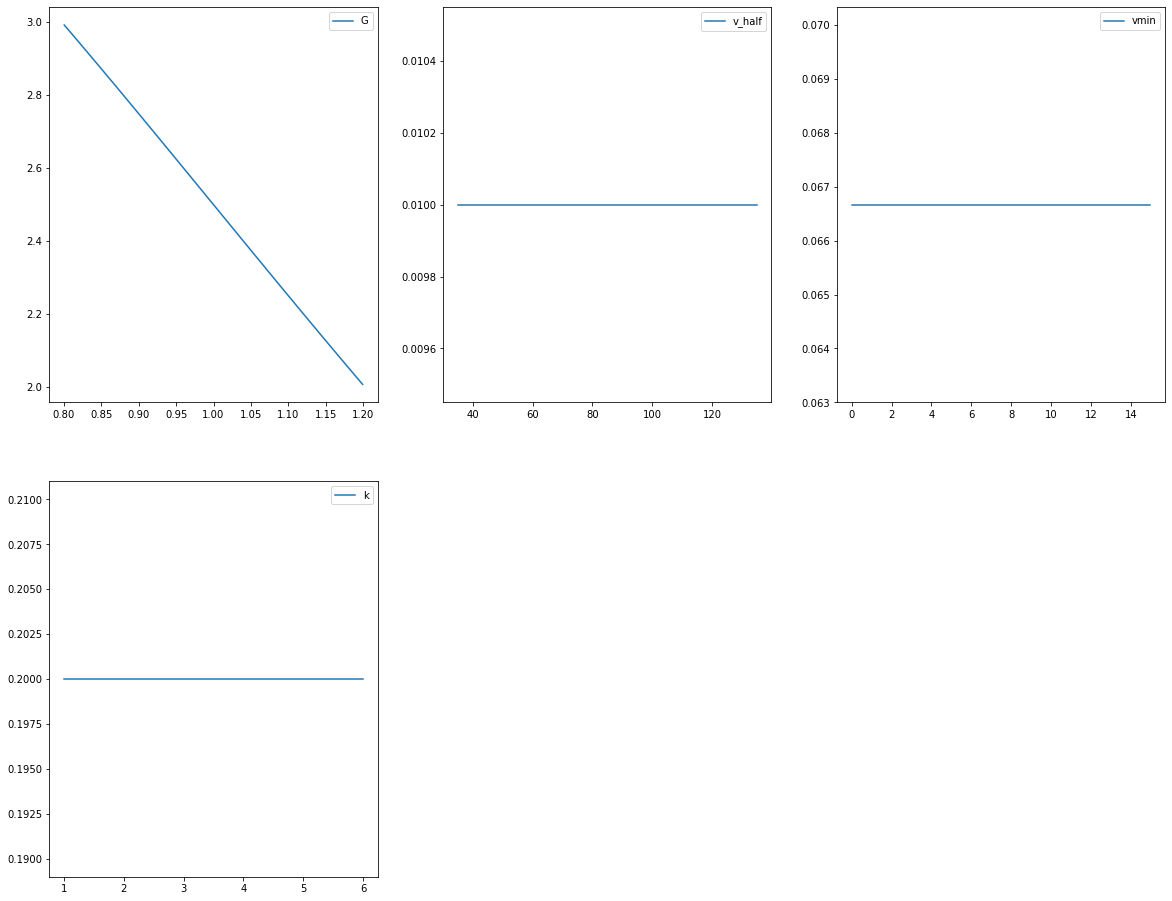

In [9]:
impf_unc.plot();

### Compute uncertainty and sensitivity using default methods 

First, we define the UncImpact object with our uncertainty variables. 

In [8]:
from climada.engine.uncertainty import UncImpact

unc = UncImpact(exp_unc, impf_unc, haz)

Next, we generate samples for the uncertainty parameters using the default methods. Note that depending on the chosen Salib method, the effective number of samples differs from the input variable N. For the default 'saltelli', with `calc_second_order=True`, the effective number is N(2D+2), with D the number of uncertainty parameters. See [SAlib](https://salib.readthedocs.io/en/latest/api.html) for more information.

In [9]:
unc.make_sample(N=100)

2021-03-25 12:43:05,484 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 1200


,x_exp,G,v_half,vmin,k
0,0.125521,0.832731,86.855469,10.151367,2.401367
1,0.833040,0.832731,86.855469,10.151367,2.401367
2,0.125521,0.815430,86.855469,10.151367,2.401367
3,0.125521,0.832731,124.941406,10.151367,2.401367
4,0.125521,0.832731,86.855469,7.514648,2.401367
...,...,...,...,...,...
1195,0.600502,1.015208,41.396484,11.037598,4.239746
1196,0.600502,0.853179,91.494141,11.037598,4.239746
1197,0.600502,0.853179,41.396484,1.560059,4.239746
1198,0.600502,0.853179,41.396484,11.037598,5.855957


The resulting samples can be visualized in plots.

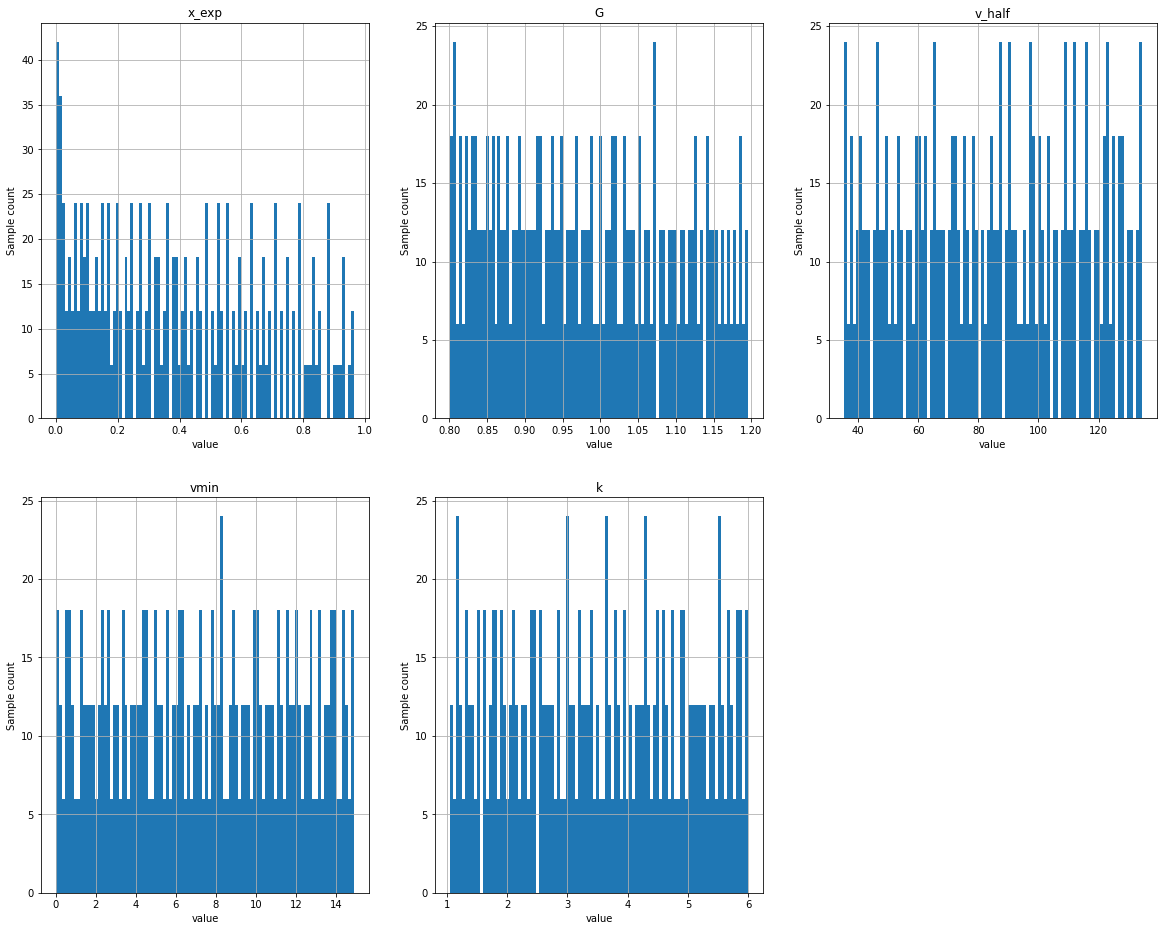

In [10]:
unc.plot_sample();

Now we can compute the value of the impact metrics for all the samples. In this example, we additionaly chose to restrict the return periods 50, 100, and 250 years. By default, `eai_exp` and `at_event` are not stored.

In [12]:
unc.calc_distribution(rp = [50, 100, 250])

2021-03-25 14:55:00,692 - climada.entity.exposures.base - INFO - centr_ not set.
2021-03-25 14:55:00,697 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-25 14:55:00,700 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-25 14:55:00,711 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-25 14:55:00,719 - climada.engine.uncertainty.unc_impact - INFO - 

Estimated computation time: 46.32s



The distributions of metrics ouputs are stored as dictionaries of pandas dataframe. The metrics are directly taken from the output of `climada.impact.calc`. 

In [26]:
unc.metrics

{'aai_agg':            aai_agg
 0     1.452259e+08
 1     9.638108e+08
 2     1.422086e+08
 3     5.798529e+07
 4     1.699837e+08
 ...            ...
 1195  3.466737e+09
 1196  8.223227e+07
 1197  3.519707e+09
 1198  2.475507e+09
 1199  2.913440e+09
 
 [1200 rows x 1 columns],
 'freq_curve':               rp50         rp100         rp250
 0     4.190439e+09  5.459388e+09  6.716189e+09
 1     2.781041e+10  3.623196e+10  4.457288e+10
 2     4.103377e+09  5.345963e+09  6.576651e+09
 3     1.668605e+09  2.195785e+09  2.728832e+09
 4     4.852968e+09  6.169638e+09  7.454678e+09
 ...            ...           ...           ...
 1195  1.027197e+11  1.440714e+11  1.832228e+11
 1196  2.242984e+09  3.585708e+09  5.083031e+09
 1197  1.027906e+11  1.314927e+11  1.574598e+11
 1198  7.067343e+10  1.096797e+11  1.503698e+11
 1199  8.632543e+10  1.210773e+11  1.539801e+11
 
 [1200 rows x 3 columns],
 'eai_exp': Empty DataFrame
 Columns: []
 Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,

The distributions of the one-dimensioanl metrics (`eai_exp` and `at_event` are not shown) can be vizualised with plots.

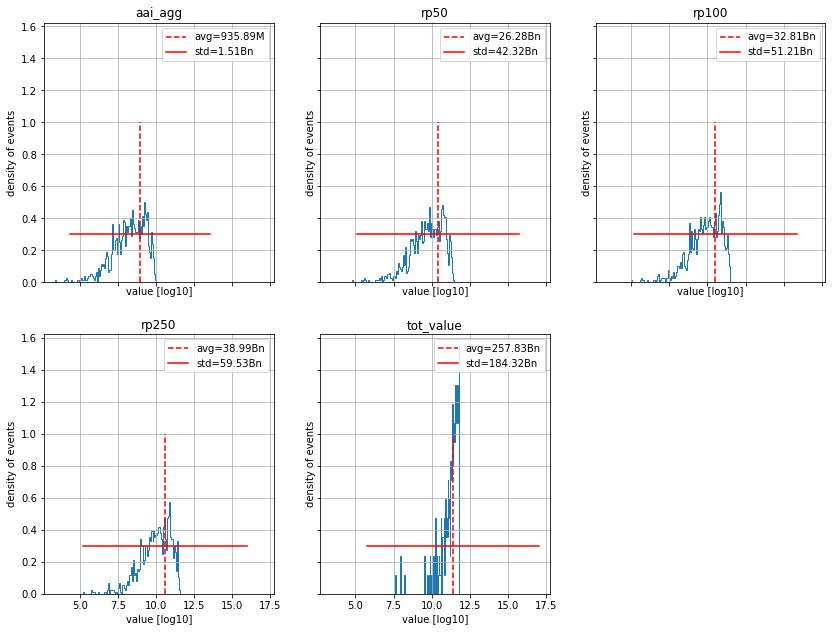

In [27]:
unc.plot_distribution();

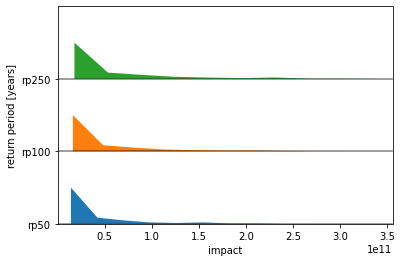

In [28]:
# Specific plot for the return period distributions
unc.plot_rp_distribution();

Now that a distribution of the impact metrics has been computed for each sample, we can also compute the sensitivity indices for each metrics to each uncertainty parameter. Note that the chosen method for the sensitivity analysis should correpond to its sampling partner as defined in the [SAlib](https://salib.readthedocs.io/en/latest/api.html) package.

The sensitivity indices dictionnaries outputs from the SAlib methods are stored in the same structure of nested dictionnaries as the metrics distributions. Note that depending on the chosen sensitivity analysis method the returned indices dictionnary will return specific types of sensitivity indices with specific names. Please get familiar with [SAlib](https://salib.readthedocs.io/en/latest/api.html) for more information.

Note that in our case, several of the second order sensitivity indices are negative. For the default method `sobol`, this indicates that the algorithm has not converged and cannot give realiable values for these sensitivity indices. If this happens, please use a larger number of samples. Here we will focus on the first-order indices.

In [29]:
unc.calc_sensitivity()

{'aai_agg': {'aai_agg': {'S1': array([0.35319533, 0.02894084, 0.29014581, 0.00245273, 0.07358847]),
   'S1_conf': array([0.18870119, 0.03802026, 0.18558693, 0.02436616, 0.11872332]),
   'ST': array([0.45797138, 0.02597843, 0.58556506, 0.01358738, 0.2763128 ]),
   'ST_conf': array([0.19310041, 0.01746177, 0.28735836, 0.00741502, 0.13919248]),
   'S2': array([[        nan, -0.24100036, -0.0349894 , -0.24132635, -0.169576  ],
          [        nan,         nan, -0.05162803, -0.04726681, -0.04375917],
          [        nan,         nan,         nan, -0.02073784,  0.00665134],
          [        nan,         nan,         nan,         nan, -0.00056325],
          [        nan,         nan,         nan,         nan,         nan]]),
   'S2_conf': array([[       nan, 0.26350234, 0.41874702, 0.26337417, 0.28392312],
          [       nan,        nan, 0.0783691 , 0.06928063, 0.05089912],
          [       nan,        nan,        nan, 0.2824616 , 0.32859625],
          [       nan,        nan,  

The value of the sensitivity indices can be plotted for each metric that is one-dimensional (`eai_exp` and `at_event` are not shown in this plot). 

As expected, the `tot_value` of the exposure is only dependent on the exposure parameter `x_exp`. We further see that both the errors in `freq_curve` and in `aai_agg` are mostly determined by `x_exp` and `v_half`. Finally, we see small differences in the sensitivity of the different return periods.

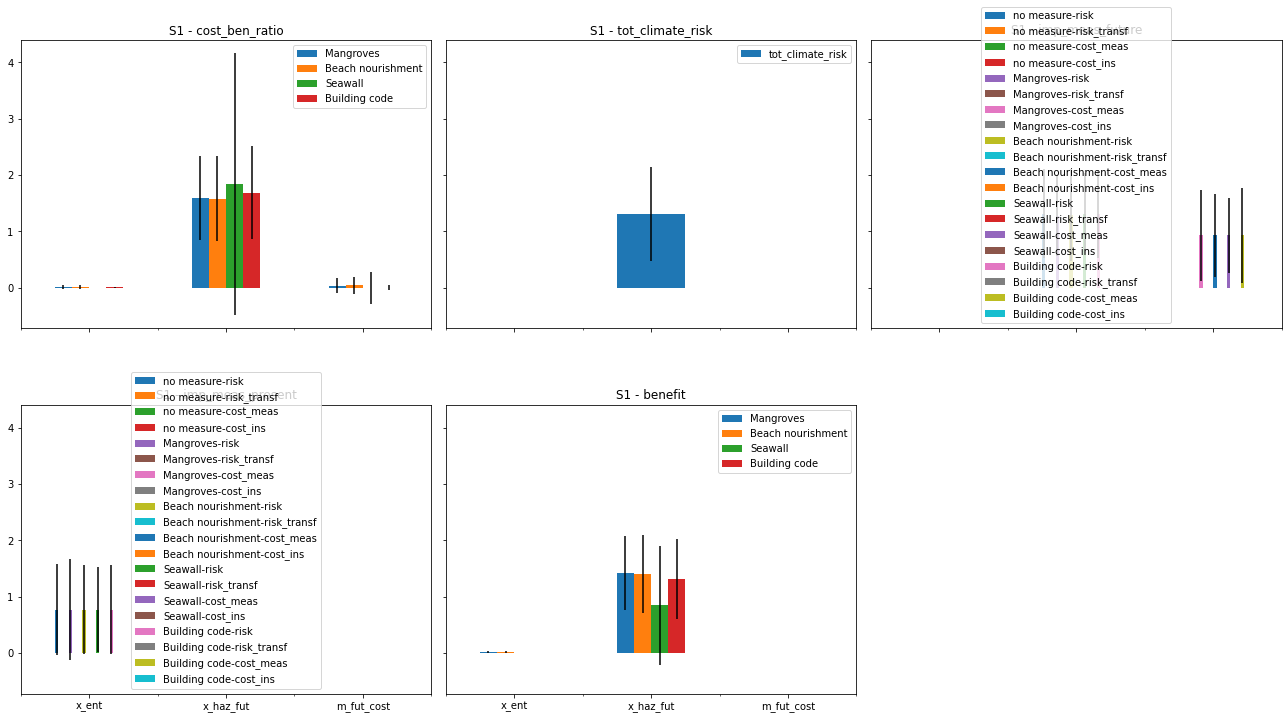

In [64]:
# Default for 'sobol' is to plot 'S1' sensitivity index.
unc.plot_sensitivity();

Note that since we have quite a few measures, the imp_meas_fut and imp_meas_pres plots are too crowded. We can select only the other metrics easily. In addition, instead of showing first order sensitivity 'S1', we can plot the total sensitivity 'ST'.

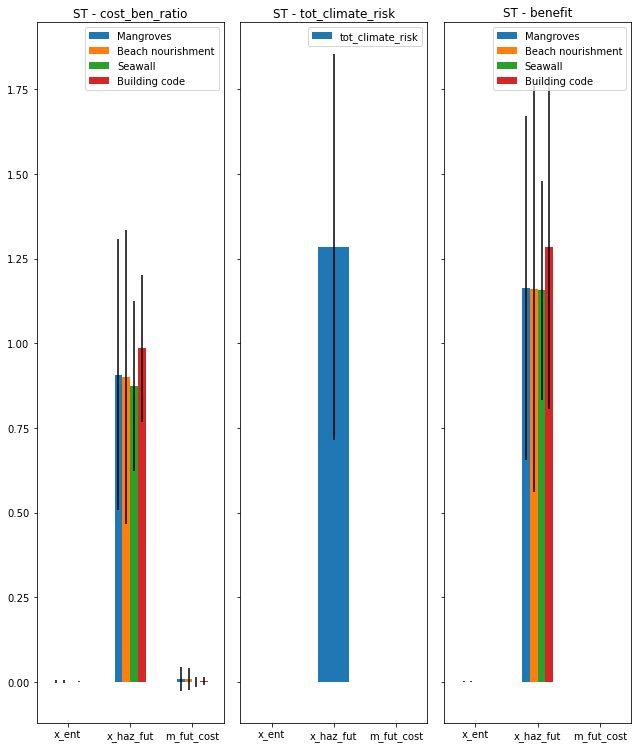

In [66]:
unc.plot_sensitivity(salib_si = 'ST', metric_list=['cost_ben_ratio', 'tot_climate_risk', 'benefit']);

### A few non-default parameters

We shall use the same uncertainty variables as in the previous section but show a few possibilities to use non-default method arguments.

In [10]:
# Sampling method "latin" hypercube instead of `saltelli`.
from climada.engine.uncertainty import UncImpact

unc = UncImpact(exp_unc, impf_unc, haz)
unc.make_sample(N=1000, sampling_method='latin')

2021-03-26 10:43:17,893 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 1000


,x_exp,G,v_half,vmin,k
0,0.610136,1.112527,55.850704,6.262395,5.278584
1,0.781237,0.916964,131.357855,11.789329,2.424171
2,0.298606,1.103691,134.347309,0.917314,2.400330
3,0.520799,0.897249,73.072926,10.772642,4.745196
4,0.542392,0.816103,120.438434,1.716603,2.496570
...,...,...,...,...,...
995,0.739182,0.847631,67.360126,11.235367,2.297320
996,0.204122,1.167215,51.514158,13.626960,5.864961
997,0.108189,0.851287,111.257468,2.490294,1.076491
998,0.229801,0.982954,124.933148,12.364088,4.131576


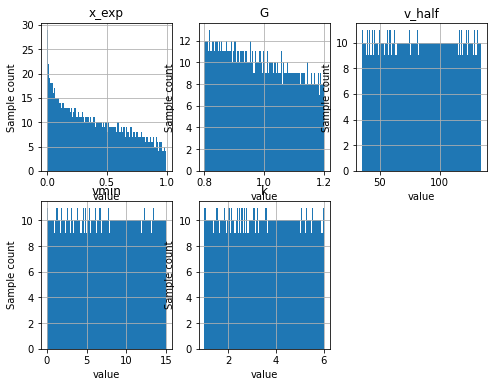

In [11]:
unc.plot_sample();

In [12]:
# Compute also the distribution of the metric `eai_exp`
# To speed-up the comutations, we use a ProcessPool for parallel computations
from pathos.pools import ProcessPool as Pool
pool = Pool()
unc.calc_distribution(rp = [50, 100, 250], calc_eai_exp=True, pool=pool)
pool.close() #Do not forget to close your pool!
pool.join()
pool.clear()

2021-03-26 10:43:19,053 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:19,056 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:19,057 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:19,065 - climada.engine.uncertainty.unc_impact - INFO - 

Estimated computation time: 2.775s

2021-03-26 10:43:19,365 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:19,371 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:19,374 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 

2021-03-26 10:43:19,503 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:19,506 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:19,505 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:19,514 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:19,512 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:19,516 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:19,519 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:19,504 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting t

2021-03-26 10:43:19,622 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:19,626 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:19,626 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:19,628 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:19,627 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:19,631 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:19,630 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:19,630 -

2021-03-26 10:43:19,704 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:19,700 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:19,705 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:19,706 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:19,667 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:19,706 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43

2021-03-26 10:43:19,764 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:19,767 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:19,770 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:19,771 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:19,772 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:19,773 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-2

2021-03-26 10:43:19,842 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:19,834 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:19,845 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:19,850 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:19,853 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:19,847 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:19,856 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 

2021-03-26 10:43:19,926 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:19,928 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:19,912 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:19,913 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:19,931 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:19,932 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
20

2021-03-26 10:43:19,999 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,000 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:19,998 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,002 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,002 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,003 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,002 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:2

2021-03-26 10:43:20,050 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,051 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,052 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,052 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,052 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,054 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,055 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,055 -

2021-03-26 10:43:20,097 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,097 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,098 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,100 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,100 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,100 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,101 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-03-26 10:43:20,185 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,184 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,186 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,188 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,189 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,186 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43

2021-03-26 10:43:20,273 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,283 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,283 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,283 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,286 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,286 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,276 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting

2021-03-26 10:43:20,364 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,365 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,366 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,366 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,367 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,368 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,369 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,375 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,

2021-03-26 10:43:20,437 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,437 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,439 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,437 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,441 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,442 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,444 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,444 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shi

2021-03-26 10:43:20,523 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,524 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,525 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,525 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,527 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,530 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,529 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 

2021-03-26 10:43:20,607 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,611 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,611 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,612 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,617 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,612 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,622 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 

2021-03-26 10:43:20,686 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,689 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,689 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,692 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,692 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,691 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,692 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,692 -

2021-03-26 10:43:20,765 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,765 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,765 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,768 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,766 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,771 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,773 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 

2021-03-26 10:43:20,845 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,847 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,848 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,850 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,854 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:20,848 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:20,849 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 

2021-03-26 10:43:20,908 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,919 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,890 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,929 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:20,929 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or pa

2021-03-26 10:43:21,000 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,000 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,003 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,003 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,004 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,006 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,008 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,008 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,009 - climada.

2021-03-26 10:43:21,073 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,073 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,067 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,076 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,077 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,073 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,080 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,072 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,088 - c

2021-03-26 10:43:21,145 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,146 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,147 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,147 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,149 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,149 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43

2021-03-26 10:43:21,230 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,233 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,235 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,233 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,237 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,238 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,238 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,243 -

2021-03-26 10:43:21,320 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,321 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,322 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,323 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,323 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,325 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,328 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,328 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting t

2021-03-26 10:43:21,385 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,384 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,388 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,389 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,389 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,397 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,358 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,359 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10

2021-03-26 10:43:21,457 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,460 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,460 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,462 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,464 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,466 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,466 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 

2021-03-26 10:43:21,551 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,549 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,551 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,554 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,554 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,554 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43

2021-03-26 10:43:21,643 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,643 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,646 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,646 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,649 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,652 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,655 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021

2021-03-26 10:43:21,732 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,732 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,736 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,737 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,733 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,739 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,741 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Con

2021-03-26 10:43:21,828 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,831 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,829 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,829 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,833 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


2021-03-26 10:43:21,896 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,897 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,897 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,898 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,902 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,902 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
20

2021-03-26 10:43:21,946 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,949 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,950 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:21,953 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,955 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:21,957 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:21,957 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-03-26 10:43:22,014 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,013 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,015 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,016 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,018 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,018 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43

2021-03-26 10:43:22,093 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,094 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,094 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,076 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,091 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,092 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,098 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:2

2021-03-26 10:43:22,189 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,195 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,150 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,193 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,194 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or pa

2021-03-26 10:43:22,314 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,313 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,318 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,319 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,320 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,321 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. C

2021-03-26 10:43:22,387 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,389 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,389 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,391 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,393 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,394 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,394 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the or

2021-03-26 10:43:22,445 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,445 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,448 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,449 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,452 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,452 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,453 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2021-03-26 10:43:22,507 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,507 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,504 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,507 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,512 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,512 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,513 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,517 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,

2021-03-26 10:43:22,642 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,641 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,646 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,652 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,653 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,656 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,639 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021

2021-03-26 10:43:22,753 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,752 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,754 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,755 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,755 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,756 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,758 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:2

2021-03-26 10:43:22,812 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,813 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,813 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,816 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,817 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,817 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,817 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,824 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10

2021-03-26 10:43:22,887 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,887 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,883 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,887 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,892 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:22,892 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:22,893 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 

2021-03-26 10:43:22,992 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,996 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:22,996 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,000 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:23,001 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensit

2021-03-26 10:43:23,088 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:23,089 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,091 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,091 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:23,095 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,096 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,096 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:2

2021-03-26 10:43:23,171 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,173 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,172 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,171 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,179 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,183 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,160 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:23,185 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10

2021-03-26 10:43:23,259 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,260 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,262 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:23,263 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,264 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,264 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:23,264 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:2

2021-03-26 10:43:23,323 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:23,324 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,326 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,327 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,327 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,328 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,329 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:2

2021-03-26 10:43:23,407 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:23,408 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,411 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,412 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,412 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:23,416 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,416 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,416 -

2021-03-26 10:43:23,496 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,497 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,497 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,500 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,502 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,503 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,506 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,504 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:23,

2021-03-26 10:43:23,589 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:23,593 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,594 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,593 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:23,594 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,594 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,594 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,596 -

2021-03-26 10:43:23,695 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:23,695 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,696 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,697 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:23,699 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,700 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,700 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,700 -

2021-03-26 10:43:23,823 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:23,827 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,827 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,831 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-26 10:43:23,836 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-26 10:43:23,840 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-26 10:43:23,844 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

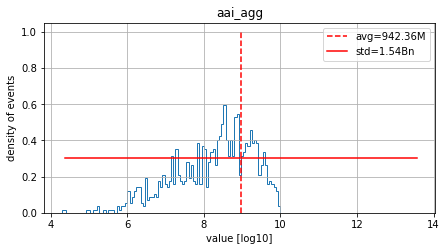

In [13]:
# plot the aai_agg distribution only
unc.plot_distribution(metric_list=['aai_agg']);

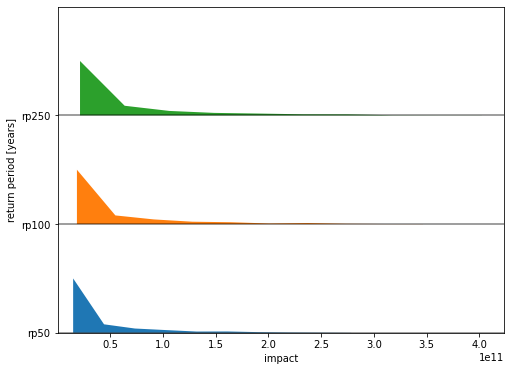

In [14]:
unc.plot_rp_distribution();

In [15]:
# Use the method 'rbd_fast' which is recommend in pair with 'latin'. In addition, change one of the kwargs 
# (M=15) of the salib sampling method.
unc.calc_sensitivity(salib_method='rbd_fast', method_kwargs = {'M': 15})

{'aai_agg': {'aai_agg': {'S1': [0.2043501392102268,
    -0.006306511573475424,
    0.3406075217736621,
    0.00603762223817704,
    0.14838934254481698],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']}},
 'freq_curve': {'rp50': {'S1': [0.2049049336477937,
    -0.005693164120303788,
    0.35937170486907405,
    0.004513773260866029,
    0.13094511030612888],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']},
  'rp100': {'S1': [0.21855368052593768,
    -0.003650848658997591,
    0.39104549168603486,
    0.0018760402559260501,
    0.09493897491016369],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']},
  'rp250': {'S1': [0.22932251855010388,
    -0.0020883289825639993,
    0.407921691566953,
    0.0003872640819558952,
    0.07057468890492866],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']}},
 'eai_exp': {0: {'S1': [0.21532948851654435,
    -0.0055305400040642425,
    0.3555133543204852,
    0.004674475425493544,
    0.13196594877071333],
   'names': ['x_exp', 'G', 'v_half', 'vmin

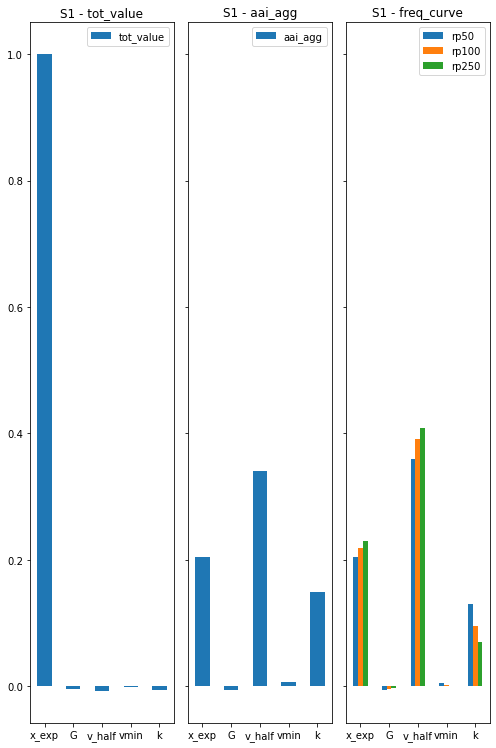

In [16]:
unc.plot_sensitivity();

Since we computed the distribution and sensitivity indices for the total impact at each exposure point, we can plot a map of the largest sensitivity index in each exposure location. This yields a rather suprising result that for every location, the most sensitive parameter is `x_exp`, the exposures scaling parameter.

In [ ]:
unc.plot_sensitivity_map(exp_base)

## UncCostBenefit

The uncertainty and sensitivity analysis for CostBenefit is completely analogous to the Impact case. It is slightly more complex as there are more input variables.

Define the uncvar_func.

In [1]:
import copy
from climada.util.constants import ENT_DEMO_TODAY, ENT_DEMO_FUTURE, HAZ_DEMO_H5
from climada.entity import Entity
from climada.hazard import Hazard

# Entity today has an uncertainty in the total asset value
def ent_today_func(x_ent):
    entity = Entity()
    entity.read_excel(ENT_DEMO_TODAY)
    entity.exposures.ref_year = 2018
    entity.exposures.gdf.value *= x_ent
    return entity

# Entity in the future has a +- 10% uncertainty in the cost of all the adapatation measures
def ent_fut_func(m_fut_cost):
    entity = Entity()
    entity.read_excel(ENT_DEMO_FUTURE)
    entity.exposures.ref_year = 2040  
    for meas in entity.measures.get_measure('TC'):
        meas.cost *= m_fut_cost
    return entity

haz_base = Hazard()
haz_base.read_hdf5(HAZ_DEMO_H5)

# The hazard intensity in the future is also uncertainty by a multiplicative factor
def haz_fut_func(x_haz_fut, haz=haz_base):
    haz = copy.deepcopy(haz_base)
    haz.intensity = haz.intensity.multiply(x_haz_fut)
    return haz


/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


2021-03-25 15:03:33,373 - climada.hazard.base - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5


Check that costs for measures are changed as desired.

In [2]:
costs_1 = [meas.cost for meas in ent_fut_func(1).measures.get_measure('TC')]
costs_05 = [meas.cost for meas in ent_fut_func(0.5).measures.get_measure('TC')]
print(f"\nThe cost for m_fut_cost=1 are {costs_1}\n"
     f"The cost for m_fut_cost=0.5 are {costs_05}")

2021-03-25 15:03:33,396 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-25 15:03:33,396 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-25 15:03:33,397 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-25 15:03:33,398 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-25 15:03:33,399 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-25 15:03:33,436 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-25 15:03:33,436 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-25 15:03:33,437 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-25 15:03:33,437 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-25 15:03:33,438 - climada.entity.exposures.base - INFO - crs set to default

Define the UncVars

In [3]:
import scipy as sp
from climada.engine.uncertainty import UncVar

haz_today = haz_base

haz_fut_distr = {"x_haz_fut": sp.stats.uniform(1, 3),
              }
haz_fut_unc = UncVar(haz_fut_func, haz_fut_distr)

ent_today_distr = {"x_ent":  sp.stats.uniform(0.7, 1)}
ent_today_unc = UncVar(ent_today_func, ent_today_distr)

ent_fut_distr = {"m_fut_cost":  sp.stats.norm(1, 0.1)}
ent_fut_unc = UncVar(ent_fut_func, ent_fut_distr)

Initialize the UncCostBenefit object and make a sample with N=10. Set `calc_second_order=False`.

In [4]:
from climada.engine.uncertainty import UncCostBenefit

unc = UncCostBenefit(haz_unc=haz_today, ent_unc=ent_today_unc,
                     haz_fut_unc=haz_fut_unc, ent_fut_unc=ent_fut_unc)
unc.make_sample(N=10, sampling_kwargs={'calc_second_order':False})

2021-03-25 15:03:35,602 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 50


,x_ent,x_haz_fut,m_fut_cost
0,0.919727,1.290039,1.004653
1,1.376758,1.290039,1.004653
2,0.919727,1.840820,1.004653
3,0.919727,1.290039,1.132387
4,1.376758,1.840820,1.132387
5,1.419727,2.790039,0.791544
6,0.876758,2.790039,0.791544
7,1.419727,3.340820,0.791544
8,1.419727,2.790039,0.976531
9,0.876758,3.340820,0.976531


For longer computations, it is possible to use a pool for parallel computation.

In [6]:
from pathos.pools import ProcessPool as Pool

pool = Pool()
unc.calc_distribution(pool=pool)
pool.close() #Do not forget to close your pool!
pool.join()
pool.clear()

2021-03-25 15:02:28,712 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-25 15:02:28,714 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-25 15:02:28,715 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-25 15:02:28,717 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-25 15:02:28,720 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-25 15:02:28,766 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-25 15:02:28,768 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-25 15:02:28,768 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-25 15:02:28,769 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-25 15:02:28,769 - climada.entity.exposures.base - INFO - crs set to default

2021-03-25 15:02:29,236 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-25 15:02:29,250 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-25 15:02:29,249 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-25 15:02:29,247 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-25 15:02:29,256 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-25 15:02:29,259 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-25 15:02:29,264 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-25 15:02:29,266 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-25 15:02:29,268 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-25 15:02:29,268 - climada.entity.exposures.base - INFO - r

2021-03-25 15:02:29,640 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-25 15:02:29,640 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-25 15:02:29,643 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-25 15:02:29,644 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-25 15:02:29,650 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-25 15:02:29,654 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-25 15:02:29,658 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-25 15:02:29,659 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-25 15:02:29,661 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-25 15:02:29,664 - climada.entity.exposures.base - INFO - meta set to defau

2021-03-25 15:02:30,076 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-25 15:02:30,081 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-25 15:02:30,081 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-25 15:02:30,085 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-25 15:02:30,086 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-25 15:02:30,085 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-25 15:02:30,089 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-25 15:02:30,092 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-25 15:02:30,094 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-25 15:02:30,09

2021-03-25 15:02:30,170 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-25 15:02:30,169 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-25 15:02:30,173 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-25 15:02:30,173 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-25 15:02:30,172 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-25 15:02:30,174 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-25 15:02:30,177 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-25 15:02:30,176 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-25 15:02:30,178 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-03-25 15:02:30,178 -

2021-03-25 15:02:30,256 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-25 15:02:30,260 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-25 15:02:30,262 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-03-25 15:02:30,265 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-25 15:02:30,266 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31787          2.75916        2.09365
Beach nourishment          1.73604          2.23365        1.28663
Seawall                    8.92009          0.00282054     0.000316201
Building code              9.2428           1.69662        0.1835612021-03-25 15:02:30,266 - climada.engine.impact - I

2021-03-25 15:02:30,633 - climada.entity.exposures.base - INFO - meta set to default value {}


In [6]:
unc.calc_distribution()

2021-03-25 15:03:49,983 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-25 15:03:49,984 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-25 15:03:49,985 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-25 15:03:49,986 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-25 15:03:49,987 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-25 15:03:50,014 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-25 15:03:50,015 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-25 15:03:50,015 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-25 15:03:50,016 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-25 15:03:50,016 - climada.entity.exposures.base - INFO - crs set to default


Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.03832           10.4022        10.0183
Beach nourishment          1.36779            8.21421        6.00547
Seawall                    7.02795            0.424078       0.0603417
Building code              7.28221           36.9875         5.07916

--------------------  --------  --------
Total climate risk:   147.95    (USD bn)
Average annual risk:   17.0906  (USD bn)
Residual risk:         91.9219  (USD bn)
--------------------  --------  --------
Net Present Values

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.03832           10.1922         9.81605
Beach nourishment          1.36779            8.04273        5.8801
Seawall                    7.02795            0.424078       0.0603417
Buil


Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.36488             7.6526         5.60678
Beach nourishment          1.79797             5.92005        3.29263
Seawall                    9.23829             1.85488        0.200781
Building code              9.57251            45.0948         4.71086

--------------------  --------  --------
Total climate risk:   180.379   (USD bn)
Average annual risk:   20.8872  (USD bn)
Residual risk:        119.857   (USD bn)
--------------------  --------  --------
Net Present Values

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.36488         1.41306         1.0353
Beach nourishment          1.79797         1.15222         0.640845
Seawall                    9.23829         0.000211051     2.28453e-05
Bui


Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.27634          10.5363         8.25508
Beach nourishment          1.68133           8.57972        5.10293
Seawall                    8.63899           0.0192535      0.00222868
Building code              8.95154           7.63263        0.852661

--------------------  --------  --------
Total climate risk:   30.5305   (USD bn)
Average annual risk:   3.48553  (USD bn)
Residual risk:         3.7626   (USD bn)
--------------------  --------  --------
Net Present Values

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.27634             7.34786        5.75697
Beach nourishment          1.68133             5.82729        3.46588
Seawall                    8.63899             2.57386        0.297936
Bu


Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.22369            9.77854        7.991
Beach nourishment          1.61198            7.44435        4.61815
Seawall                    8.28264            0.510076       0.0615838
Building code              8.58229           38.0512         4.43368

--------------------  --------  --------
Total climate risk:   152.205   (USD bn)
Average annual risk:   17.6093  (USD bn)
Residual risk:         96.4205  (USD bn)
--------------------  --------  --------
Net Present Values

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.32819            8.81404        6.63614
Beach nourishment          1.74963            6.91414        3.95177
Seawall                    8.98991            0.751479       0.0835913
Buil

The output of `CostBenefit.calc` is rather complex in its structure. The metrics dictionary inherits this complexity.

In [9]:
#Top level metrics keys
macro_metrics = list(unc.metrics.keys())
macro_metrics

['tot_climate_risk',
 'benefit',
 'cost_ben_ratio',
 'imp_meas_present',
 'imp_meas_future']

In [16]:
# The benefits and the cost_ben_ratio are available for each measuret
print(list(unc.metrics['benefit'].keys()))
print(list(unc.metrics['cost_ben_ratio'].keys()))

['Mangroves', 'Beach nourishment', 'Seawall', 'Building code']
['Mangroves', 'Beach nourishment', 'Seawall', 'Building code']


In [18]:
# The impact_meas_present and impact_meas_future provide values of the cost_meas, risk_transf, risk, 
# and cost_ins for each measure
print(list(unc.metrics['imp_meas_present'].keys()))
print(list(unc.metrics['imp_meas_future'].keys()))

['no measure-risk', 'no measure-risk_transf', 'no measure-cost_meas', 'no measure-cost_ins', 'Mangroves-risk', 'Mangroves-risk_transf', 'Mangroves-cost_meas', 'Mangroves-cost_ins', 'Beach nourishment-risk', 'Beach nourishment-risk_transf', 'Beach nourishment-cost_meas', 'Beach nourishment-cost_ins', 'Seawall-risk', 'Seawall-risk_transf', 'Seawall-cost_meas', 'Seawall-cost_ins', 'Building code-risk', 'Building code-risk_transf', 'Building code-cost_meas', 'Building code-cost_ins']
['no measure-risk', 'no measure-risk_transf', 'no measure-cost_meas', 'no measure-cost_ins', 'Mangroves-risk', 'Mangroves-risk_transf', 'Mangroves-cost_meas', 'Mangroves-cost_ins', 'Beach nourishment-risk', 'Beach nourishment-risk_transf', 'Beach nourishment-cost_meas', 'Beach nourishment-cost_ins', 'Seawall-risk', 'Seawall-risk_transf', 'Seawall-cost_meas', 'Seawall-cost_ins', 'Building code-risk', 'Building code-risk_transf', 'Building code-cost_meas', 'Building code-cost_ins']


We can plot the distributions for the top metrics or our choice.

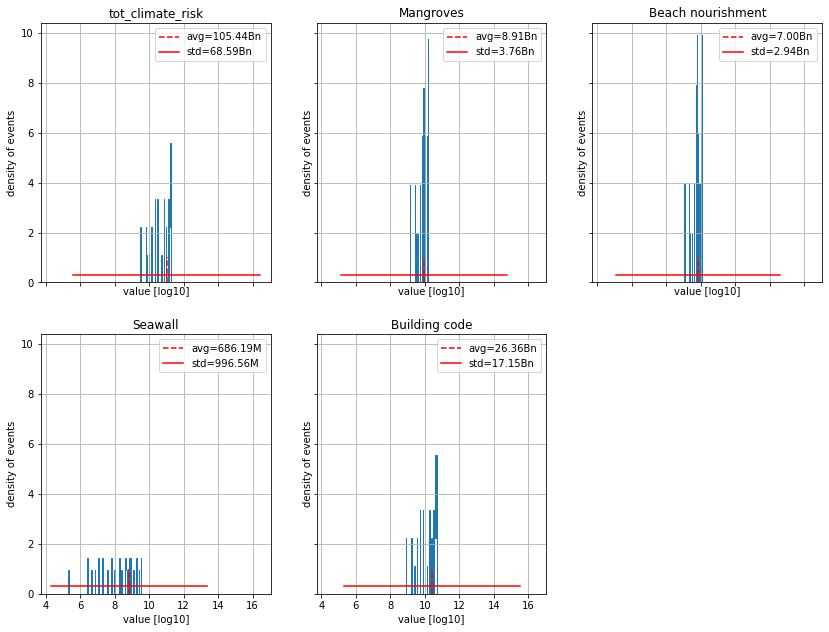

In [25]:
# tot_climate_risk and benefit
unc.plot_distribution(metric_list=['tot_climate_risk', 'benefit']);

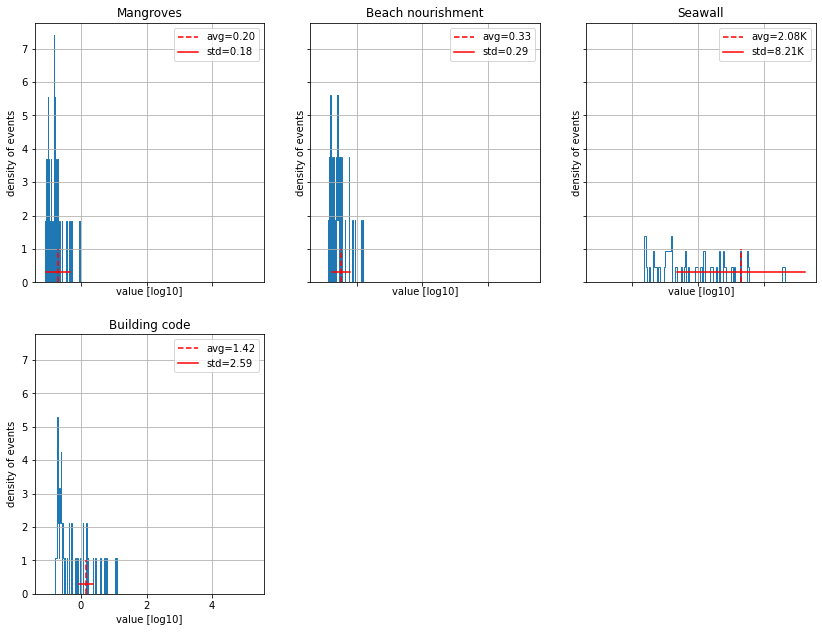

In [26]:
# cost benefit ratio
unc.plot_distribution(metric_list=['cost_ben_ratio'] );

Analogously to the impact example, now that we have a metric distribution, we can compute the sensitivity indices. Since we used the default sampling method, we can use the default sensitivity analysis method. However, since we used `calc_second_order = False` for the sampling, we need to specify the same for the sensitivity analysis.

In [28]:
unc.calc_sensitivity(method_kwargs = {'calc_second_order':False})

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:93: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib

{'tot_climate_risk': {'tot_climate_risk': {'S1': array([-0.00203406,  1.30805651,  0.        ]),
   'S1_conf': array([0.00199424, 0.83807391, 0.        ]),
   'ST': array([8.55006831e-06, 1.28467639e+00, 0.00000000e+00]),
   'ST_conf': array([6.40525205e-06, 5.69021366e-01, 0.00000000e+00])}},
 'benefit': {'Mangroves': {'S1': array([0.01508364, 1.4234898 , 0.        ]),
   'S1_conf': array([0.02406296, 0.6547753 , 0.        ]),
   'ST': array([6.71986555e-04, 1.16378579e+00, 0.00000000e+00]),
   'ST_conf': array([0.00079439, 0.50723934, 0.        ])},
  'Beach nourishment': {'S1': array([0.01557013, 1.40197455, 0.        ]),
   'S1_conf': array([0.02380884, 0.69666146, 0.        ]),
   'ST': array([7.37074244e-04, 1.15982867e+00, 0.00000000e+00]),
   'ST_conf': array([0.00074987, 0.59908165, 0.        ])},
  'Seawall': {'S1': array([0.        , 0.84541059, 0.        ]),
   'S1_conf': array([0.        , 1.06049347, 0.        ]),
   'ST': array([0.       , 1.1560475, 0.       ]),
   'ST_

The sensitivity indices can be plotted. For the default method 'sobol', by default the 'S1' sensitivity index is plotted.

Note that since we have quite a few measures, the plot must be adjusted a bit or dropped. Also see that for many metrics, the sensitivity to certain uncertainty parameters appears to be 0. However, this result is to be treated with care. Indeed, we used for demonstration purposes a rather too low number of samples, which is indicated by large confidence intervals (vertical black lines) for most sensitivity indices. For a more robust result the analysis should be repeated with more samples.

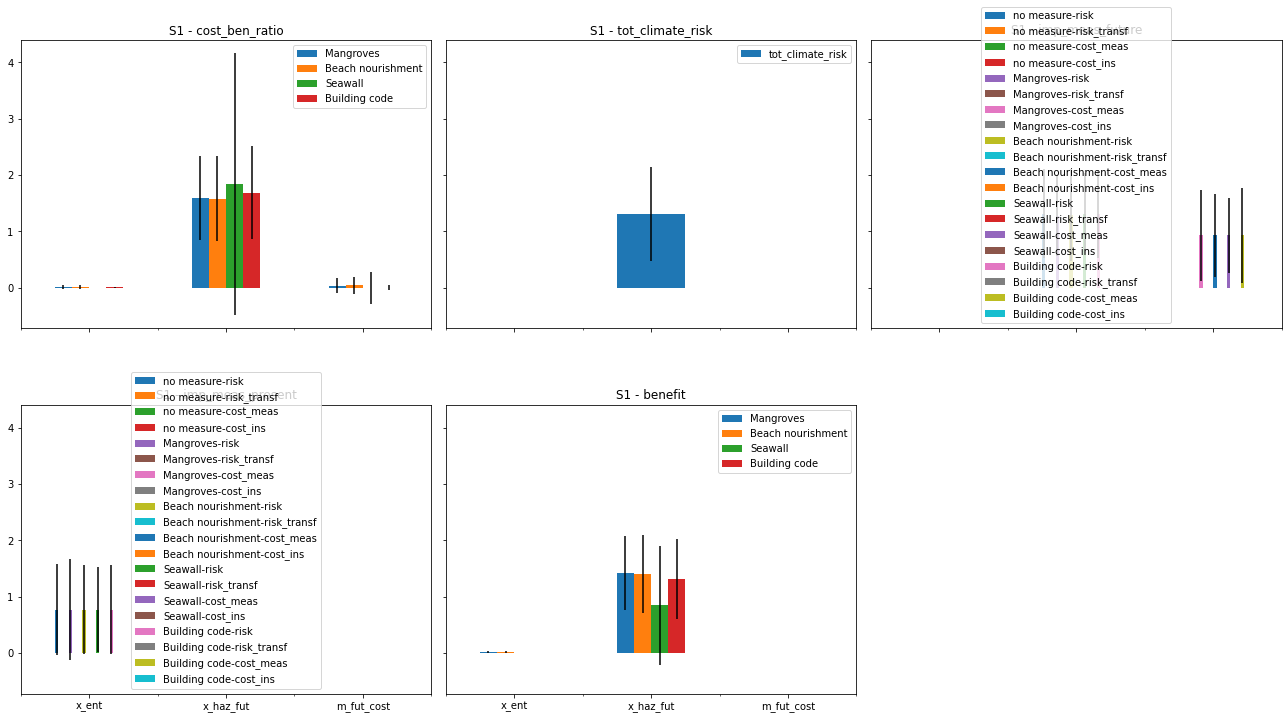

In [61]:
fig, axes = unc.plot_sensitivity();

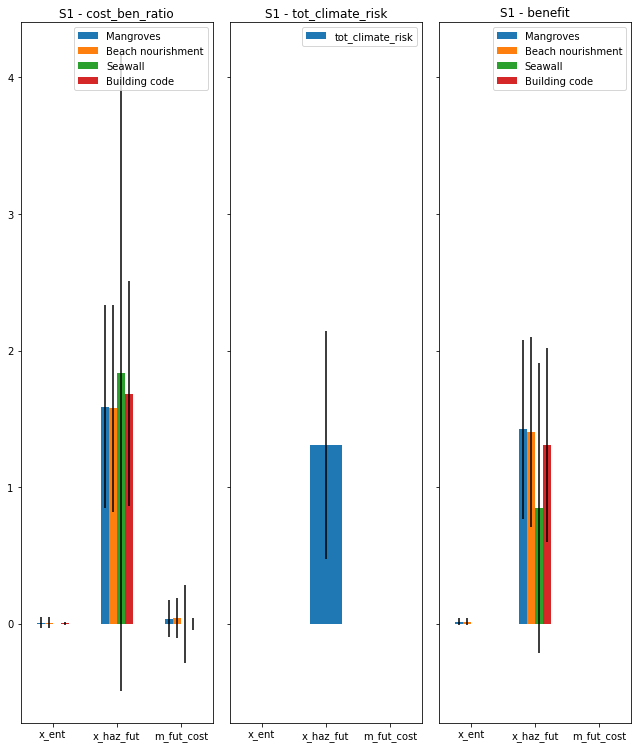

In [63]:
fig, axes = unc.plot_sensitivity(metric_list=['cost_ben_ratio','tot_climate_risk','benefit']);
